Purpose: Pull out top predictors (genes) from RF results on BioProject-corrected TPM (both for all samples and for photosynthetic tissues only), then use these to find core genes from RF.<br>
Author: Anna Pardo<br>
Date initiated: Mar. 12, 2024

In [14]:
# load modules
import pandas as pd
import matplotlib.pyplot as plt
import os
from venn import venn

In [6]:
# function to pull out the top X% of features in a given dict
def topX(fi_dict,X):
    quant = (100-X)/100
    topXdict = {}
    for k in fi_dict:
        df = fi_dict[k]
        threshold = df["Feature_Importance"].quantile(q=quant)
        topXdict[k] = df[df["Feature_Importance"]>=threshold]
        
    setstopX = {}
    for k in topXdict:
        setstopX[k] = set(list(topXdict[k]["GeneID"]))
        
    setslist = [setstopX["Cold"],setstopX["Heat"],setstopX["Flooding"],setstopX["Low_Nitrogen"],setstopX["Drought"],
               setstopX["Salt"]]
    
    totalgenes = set.union(*setslist)
    coregenes = set.intersection(*setslist)
    
    print((len(coregenes)/len(totalgenes))*100)
    
    return totalgenes, coregenes

In [7]:
# build a function for top predictor extraction
def extract_top_preds(directory,percentage):
    # make dictionary of FI dataframes
    fid = {}
    for subd in os.listdir(directory):
        s = subd.split("T")[0]
        for f in os.listdir(directory+subd):
            if f.endswith("_sorted.tsv"):
                fid[s] = pd.read_csv(directory+subd+"/"+f,sep="\t",header="infer")
                
    tgX, cgX = topX(fid,percentage)
    
    return tgX, cgX

In [8]:
psyn_total, psyn_core = extract_top_preds("../../data/RF_outputs_bpcor_psyn/",20)

2.5507320832263036


In [9]:
all_total, all_core = extract_top_preds("../../data/06-Mar-2024_RF_BPcor_allsamp/",20)

1.4573801050669377


In [10]:
# make a function to load & wrangle core genes from set ops
def setopscore(upfile,downfile):
    cgup = pd.read_csv(upfile,sep="\t",header=None)
    cgdown = pd.read_csv(downfile,sep="\t",header=None)
    
    cgu = set(list(cgup[0]))
    cgd = set(list(cgdown[0]))
    
    return cgu.union(cgd)

In [11]:
d = "../../data/"
all_socore = setopscore(os.path.join(d,"core_upgenes_fromsets_all_corrBP.txt"),
                        os.path.join(d,"core_downgenes_fromsets_all_corrBP.txt"))
psyn_socore = setopscore(os.path.join(d,"core_upgenes_fromsets_psyn_corrBP.txt"),
                        os.path.join(d,"core_downgenes_fromsets_psyn_corrBP.txt"))

In [12]:
# how much overlap is there between RF & set ops core genes for each dataset?
print("Overlap between RF & set ops for all samples corrected:",len(all_socore.intersection(all_core)))
print("Overlap between RF & set ops for photosynthetic tissues corrected:",len(psyn_socore.intersection(psyn_core)))

Overlap between RF & set ops for all samples corrected: 31
Overlap between RF & set ops for photosynthetic tissues corrected: 37


In [13]:
# how many total core genes are there for each dataset?
all_fullcore = all_socore.union(all_core)
psyn_fullcore = psyn_socore.union(psyn_core)

print("Number of total core genes for all samples corrected:",len(all_fullcore))
print("Number of total core genes for photosynthetic tissues corrected:",len(psyn_fullcore))

Number of total core genes for all samples corrected: 568
Number of total core genes for photosynthetic tissues corrected: 1145


In [15]:
# load core genes from uncorrected data
noPCB_fullcore = set(list(pd.read_csv(os.path.join(d,"union_core_stress_genes.txt"),sep="\t",header=None)[0]))

In [16]:
venndict = {"Uncorrected data":noPCB_fullcore,"All samples corrected":all_fullcore,"Photosynthetic tissues corrected":psyn_fullcore}

<AxesSubplot: >

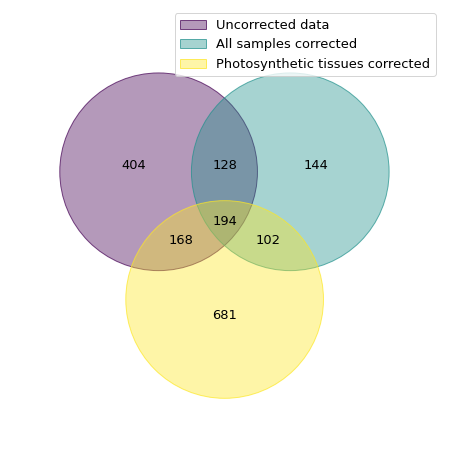

In [17]:
venn(venndict)

<AxesSubplot: >

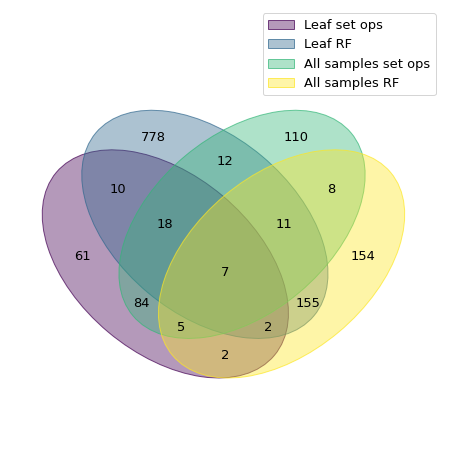

In [18]:
# make a few more Venn diagrams

corrvenn = {"Leaf set ops":psyn_socore,"Leaf RF":psyn_core,"All samples set ops":all_socore,"All samples RF":all_core}
venn(corrvenn)

<AxesSubplot: >

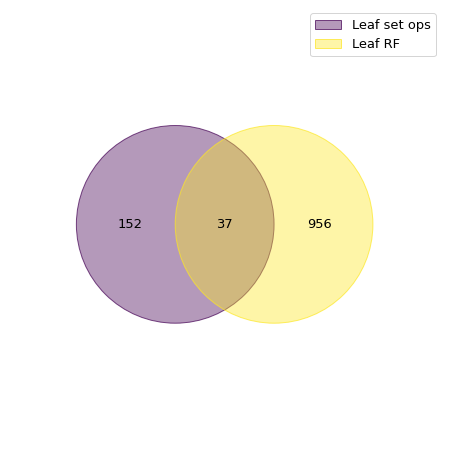

In [19]:
venn({"Leaf set ops":psyn_socore,"Leaf RF":psyn_core})

<AxesSubplot: >

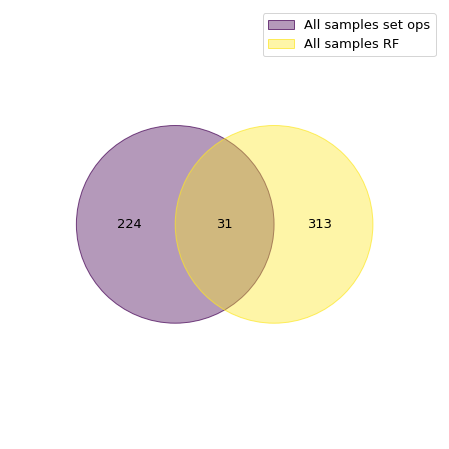

In [20]:
venn({"All samples set ops":all_socore,"All samples RF":all_core})

In [21]:
def setops_core_reg(upfile,downfile):
    cgup = pd.read_csv(upfile,sep="\t",header=None)
    cgdown = pd.read_csv(downfile,sep="\t",header=None)
    
    cgu = set(list(cgup[0]))
    cgd = set(list(cgdown[0]))
    
    return cgu,cgd

In [22]:
d = "../../data/"
all_socore_up,all_socore_down = setops_core_reg(os.path.join(d,"core_upgenes_fromsets_all_corrBP.txt"),
                        os.path.join(d,"core_downgenes_fromsets_all_corrBP.txt"))
psyn_socore_up,psyn_socore_down = setops_core_reg(os.path.join(d,"core_upgenes_fromsets_psyn_corrBP.txt"),
                        os.path.join(d,"core_downgenes_fromsets_psyn_corrBP.txt"))